# COVID-19 IMAGE CLASSIFICATION

In [1]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import warnings
import cv2
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation,BatchNormalization
from tensorflow.keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.applications.vgg19 import preprocess_input

In [2]:
name_class = os.listdir("/kaggle/input/covid19-image-dataset/Covid19-dataset/train")
name_class

['Normal', 'Viral Pneumonia', 'Covid']

In [3]:
file_path="/kaggle/input/covid19-image-dataset/Covid19-dataset/train/"
filepaths = list(glob.glob(file_path+'/**/*.*'))
image_counts={}
for c in name_class:
    path=file_path+c
    count=len(os.listdir(path))
    image_counts[c]=count

df = pd.DataFrame.from_dict(image_counts,orient='index')
df

,0
Normal,70
Viral Pneumonia,70
Covid,111


In [4]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Filepath,Label
0,/kaggle/input/covid19-image-dataset/Covid19-da...,Viral Pneumonia
1,/kaggle/input/covid19-image-dataset/Covid19-da...,Viral Pneumonia
2,/kaggle/input/covid19-image-dataset/Covid19-da...,Viral Pneumonia
3,/kaggle/input/covid19-image-dataset/Covid19-da...,Viral Pneumonia
4,/kaggle/input/covid19-image-dataset/Covid19-da...,Normal


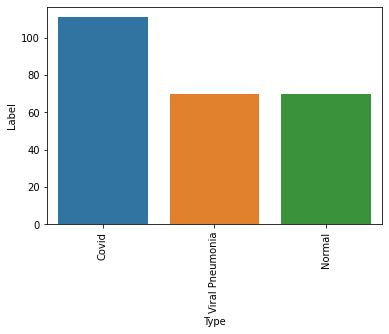

In [5]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [6]:
# Shape of the Image
from PIL import Image
img = Image.open(data.Filepath[1])
arr=np.array(img)
arr.shape

(1416, 1960, 3)

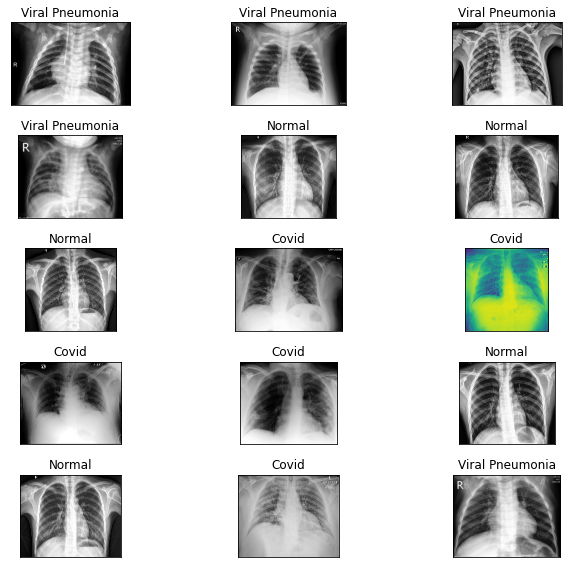

In [7]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [8]:
#Defining Image Data Generator
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.2)

In [9]:
#Setting up the images for image data generator
train_dir = "/kaggle/input/covid19-image-dataset/Covid19-dataset/train/"
test_dir = "/kaggle/input/covid19-image-dataset/Covid19-dataset/test/"

In [10]:
train_data = ImageDataGenerator(rescale = 1/255.0 , validation_split=0.2)
test_data = ImageDataGenerator(rescale = 1/255.0)

In [11]:
train_set = train_data.flow_from_directory(
                    train_dir,
                    subset = 'training',
                    batch_size=32,
                    target_size=(224,224),
                    class_mode = 'sparse'
)
val_set = train_data.flow_from_directory(
                    train_dir,
                    subset = 'validation',
                    batch_size=32,
                    target_size=(224,224),
                    class_mode = 'sparse'
)
test_set = test_data.flow_from_directory(
                    test_dir,
                    batch_size=32,
                    target_size=(224,224),
                    class_mode = 'sparse'
)

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [12]:
train_set.class_indices

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

In [13]:
y_train = train_set.classes 
y_val = val_set.classes
y_test = test_set.classes 

In [14]:
x_train = []
for folder in os.listdir(train_dir):
    sub_path = train_dir + '/' + folder
    for image in os.listdir(sub_path):
        img_path = sub_path + '/' + image
        img = cv2.imread(img_path)
        img = cv2.resize(img,(224,224)) #VGG19 needs an input of shape 224x224
        x_train.append(img)

In [15]:
x_test = []
for folder in os.listdir(test_dir):
    sub_test = test_dir + '/' + folder
    for image in os.listdir(sub_test):
        img_test = sub_test + '/' + image
        imgtest = cv2.imread(img_test)
        imgtest = cv2.resize(imgtest,(224,224))
        x_test.append(imgtest)

In [16]:
train = np.array(x_train)/255.0
test = np.array(x_test)/255.0

In [17]:
print('train data shape : ' , train.shape)
print('test data shape : ' , test.shape)

train data shape :  (251, 224, 224, 3)
test data shape :  (66, 224, 224, 3)


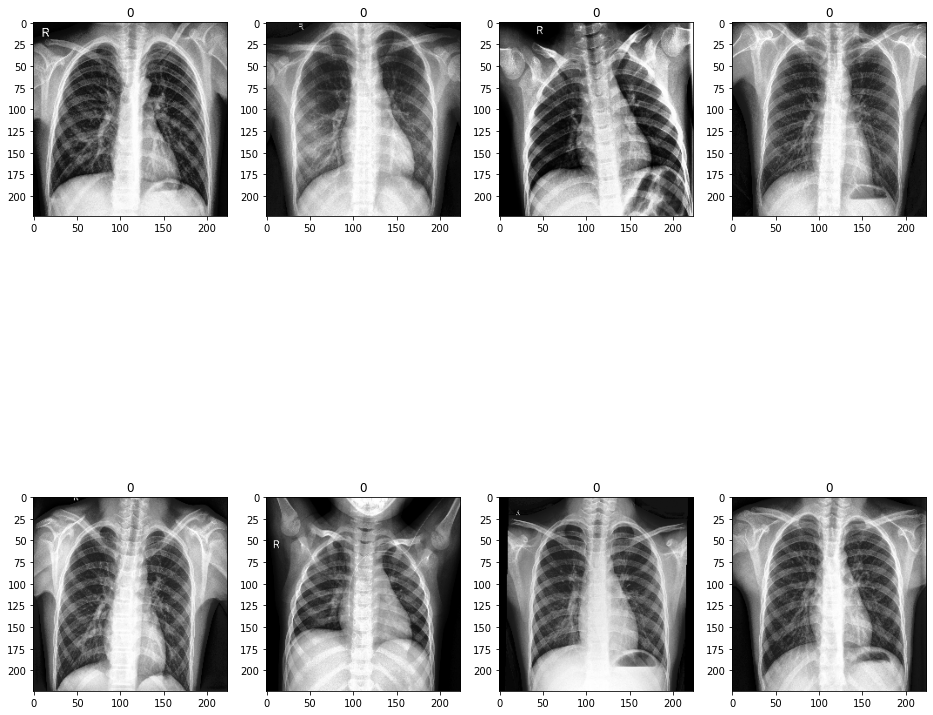

In [18]:
plt.figure(figsize=(16,16))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(train[i])
    plt.title(y_train[i])

# VGG19

In [19]:
from tensorflow.keras.applications import VGG19

In [20]:
vgg = VGG19(include_top = False , input_shape = (224,224,3),weights='imagenet')
for layer in vgg.layers :
    layer.trainable = False

80150528/80134624 [==============================] - 4s 0us/step


In [21]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
es1 = tf.keras.callbacks.EarlyStopping(
    patience = 10,
    min_delta = 0.001,
    verbose = 0
)
mc1 = ModelCheckpoint('best_model1.h5', monitor='val_loss', mode='min', verbose=1)
model1 = tf.keras.Sequential([
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(factor=0.2),
    vgg,
    layers.Flatten(),
    layers.Dense(3, activation='softmax')
])
model1.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [22]:
training = model1.fit_generator(
    train_set,
    callbacks=[es1, mc1],
    steps_per_epoch =  5,
    epochs = 10,
    validation_data = val_set
)

Epoch 1/10
5/5 [==============================] - 16s 3s/step - loss: 1.9007 - accuracy: 0.5312 - val_loss: 1.0595 - val_accuracy: 0.5400

Epoch 00001: saving model to best_model1.h5
Epoch 2/10
5/5 [==============================] - 9s 2s/step - loss: 1.0166 - accuracy: 0.6058 - val_loss: 0.8680 - val_accuracy: 0.6000

Epoch 00002: saving model to best_model1.h5
Epoch 3/10
5/5 [==============================] - 8s 2s/step - loss: 0.8671 - accuracy: 0.7226 - val_loss: 0.8277 - val_accuracy: 0.5800

Epoch 00003: saving model to best_model1.h5
Epoch 4/10
5/5 [==============================] - 9s 2s/step - loss: 0.8162 - accuracy: 0.7007 - val_loss: 0.7264 - val_accuracy: 0.7200

Epoch 00004: saving model to best_model1.h5
Epoch 5/10
5/5 [==============================] - 8s 2s/step - loss: 0.6763 - accuracy: 0.7080 - val_loss: 0.5114 - val_accuracy: 0.7600

Epoch 00005: saving model to best_model1.h5
Epoch 6/10
5/5 [==============================] - 9s 2s/step - loss: 0.4812 - accuracy: 0

In [23]:
# load a saved model
from keras.models import load_model
saved_model1 = load_model('best_model1.h5')

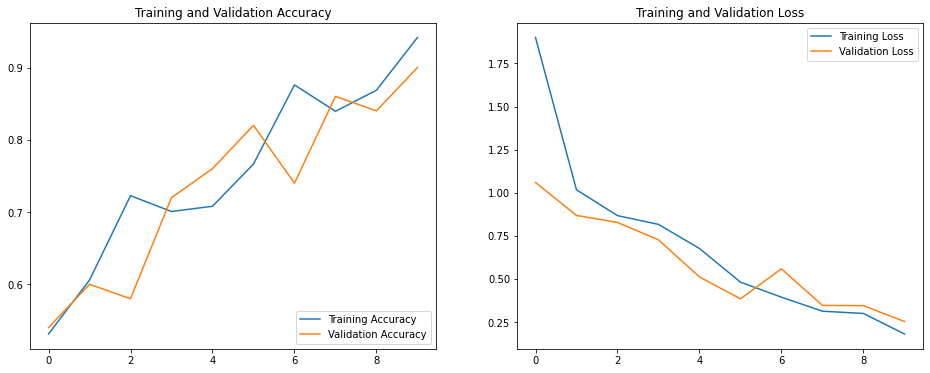

In [24]:
#Plotting the model results

#Getting the accuracy
acc1 = training.history['accuracy']
val_acc1 = training.history['val_accuracy']

#Getting the losses
loss1 = training.history['loss']
val_loss1 = training.history['val_loss']

#No of epochs it trained
epochs_range1 = training.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range1, acc1, label='Training Accuracy')
plt.plot(epochs_range1, val_acc1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range1, loss1, label='Training Loss')
plt.plot(epochs_range1, val_loss1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
pred1 = saved_model1.evaluate(test_set)

3/3 [==============================] - 2s 512ms/step - loss: 0.2478 - accuracy: 0.8636


In [26]:
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
pred1=saved_model1.predict_generator(test_set)
y_pred1=np.argmax(pred1,axis=1)
print('Confusion matrix')
print(confusion_matrix(test_set.classes,y_pred1))
print('Classification_report')
target_names=['0','1','2']
print(classification_report(test_set.classes,y_pred1,target_names=target_names))

Confusion matrix
[[ 8  7 11]
 [ 9  6  5]
 [ 9  4  7]]
Classification_report
              precision    recall  f1-score   support

           0       0.31      0.31      0.31        26
           1       0.35      0.30      0.32        20
           2       0.30      0.35      0.33        20

    accuracy                           0.32        66
   macro avg       0.32      0.32      0.32        66
weighted avg       0.32      0.32      0.32        66



Covid


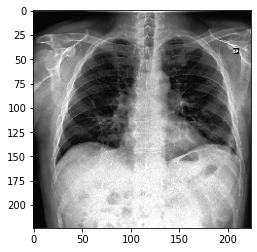

In [27]:
# for only one prediction
from keras.preprocessing import image

test_image = image.load_img('/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Covid/0100.jpeg',target_size=(224,224))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = saved_model1.predict(test_image)
train_set.class_indices
if result[0][0] == 0:
    prediction = 'Covid'
elif ( result[0][0] == 1) :
    prediction = 'Normal'
else:
    prediction = 'Viral Pneumonia'
print(prediction)

# INCEPTIONV3

In [28]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras import Model

In [29]:
model2 = InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top=False)

x=model2.output
for layer in model2.layers:
    layer.trainable = False
x=Flatten()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
x=Dropout(0.6)(x)
x=Dense(256,activation='relu')(x)
x=Dense(128,activation='relu')(x)
x=Dense(64,activation='relu')(x)
x=Dropout(0.6)(x)
predictions=Dense(3,activation='softmax')(x)
Inception_final=Model(model2.input,predictions)

87924736/87910968 [==============================] - 5s 0us/step


In [30]:
Inception_final.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [31]:
Inception_final.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [32]:
es2=EarlyStopping(monitor='val_loss',patience=5,verbose=1)
mc2 = ModelCheckpoint('inception_bestmodel1.h5', monitor='val_loss', mode='min', verbose=1)
hist2=Inception_final.fit(train_set,epochs=10,batch_size=7,callbacks=[es2,mc2],validation_data = val_set)

Epoch 1/10
7/7 [==============================] - 17s 2s/step - loss: 14.8860 - accuracy: 0.3881 - val_loss: 1.8155 - val_accuracy: 0.5800

Epoch 00001: saving model to inception_bestmodel1.h5
Epoch 2/10
7/7 [==============================] - 11s 2s/step - loss: 17.0296 - accuracy: 0.3930 - val_loss: 4.4869 - val_accuracy: 0.5800

Epoch 00002: saving model to inception_bestmodel1.h5
Epoch 3/10
7/7 [==============================] - 10s 1s/step - loss: 8.9907 - accuracy: 0.4428 - val_loss: 0.9826 - val_accuracy: 0.6200

Epoch 00003: saving model to inception_bestmodel1.h5
Epoch 4/10
7/7 [==============================] - 10s 1s/step - loss: 4.8774 - accuracy: 0.5572 - val_loss: 1.9655 - val_accuracy: 0.6000

Epoch 00004: saving model to inception_bestmodel1.h5
Epoch 5/10
7/7 [==============================] - 10s 1s/step - loss: 3.4232 - accuracy: 0.5920 - val_loss: 0.6647 - val_accuracy: 0.7400

Epoch 00005: saving model to inception_bestmodel1.h5
Epoch 6/10
7/7 [======================

In [33]:
# load a saved model
from keras.models import load_model
saved_model2 = load_model('inception_bestmodel1.h5')

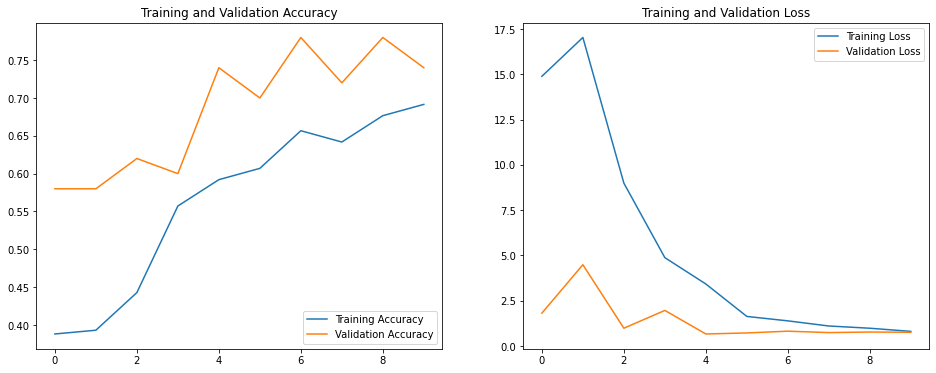

In [34]:
#Plotting the model results

#Getting the accuracy
acc2 = hist2.history['accuracy']
val_acc2 = hist2.history['val_accuracy']

#Getting the losses
loss2 = hist2.history['loss']
val_loss2 = hist2.history['val_loss']

#No of epochs it trained
epochs_range2 = hist2.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range2, acc2, label='Training Accuracy')
plt.plot(epochs_range2, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range2, loss2, label='Training Loss')
plt.plot(epochs_range2, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
pred2 = saved_model2.evaluate(test_set)

3/3 [==============================] - 3s 531ms/step - loss: 0.5384 - accuracy: 0.6667


In [36]:
pred2=saved_model2.predict_generator(test_set)
y_pred2=np.argmax(pred2,axis=1)
print('Confusion matrix')
print(confusion_matrix(test_set.classes,y_pred2))
print('Classification_report')
target_names=['0','1','2']
print(classification_report(test_set.classes,y_pred2,target_names=target_names))

Confusion matrix
[[ 9  2 15]
 [ 7  0 13]
 [ 9  2  9]]
Classification_report
              precision    recall  f1-score   support

           0       0.36      0.35      0.35        26
           1       0.00      0.00      0.00        20
           2       0.24      0.45      0.32        20

    accuracy                           0.27        66
   macro avg       0.20      0.27      0.22        66
weighted avg       0.22      0.27      0.23        66



Normal


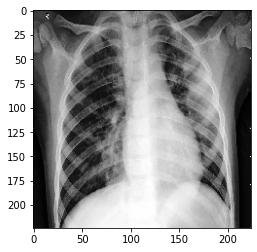

In [37]:
# for only one prediction
from keras.preprocessing import image

test_image = image.load_img('/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Viral Pneumonia/0101.jpeg',target_size=(224,224))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = saved_model2.predict(test_image)
train_set.class_indices
if result[0][0] == 0:
    prediction = 'Covid'
elif ( result[0][0] == 1) :
    prediction = 'Normal'
else:
    prediction = 'Viral Pneumonia'
print(prediction)

# CUSTOM CNN

In [38]:
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [39]:
model=Sequential()

#covolution layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3),
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
#covolution layer
model.add(Conv2D(32,(3,3),activation='relu',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
#covolution layer
model.add(Conv2D(64,(3,3),activation='relu',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
#covolution layer
model.add(Conv2D(64,(3,3),activation='relu',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
#i/p layer
model.add(Flatten())
#o/p layer
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 111, 111, 32)      128       
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 54, 54, 32)        128       
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 52, 52, 64)       

In [40]:
from tensorflow.keras.callbacks import EarlyStopping
es3=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
mc3 = ModelCheckpoint('cnn_model.h5', monitor='val_loss', mode='min', verbose=1)

In [41]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
hist3=model.fit(train_set,epochs=10,batch_size=5,callbacks=[es3,mc3],validation_data = val_set, verbose=1)

Epoch 1/10
7/7 [==============================] - 12s 2s/step - loss: 0.7580 - accuracy: 0.7711 - val_loss: 1.0275 - val_accuracy: 0.4800

Epoch 00001: saving model to cnn_model.h5
Epoch 2/10
7/7 [==============================] - 10s 1s/step - loss: 0.2096 - accuracy: 0.9502 - val_loss: 1.0005 - val_accuracy: 0.4400

Epoch 00002: saving model to cnn_model.h5
Epoch 3/10
7/7 [==============================] - 10s 1s/step - loss: 0.1604 - accuracy: 0.9502 - val_loss: 1.2235 - val_accuracy: 0.4400

Epoch 00003: saving model to cnn_model.h5
Epoch 4/10
7/7 [==============================] - 10s 2s/step - loss: 0.0261 - accuracy: 0.9851 - val_loss: 1.7546 - val_accuracy: 0.4400

Epoch 00004: saving model to cnn_model.h5
Epoch 5/10
7/7 [==============================] - 9s 1s/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 2.2083 - val_accuracy: 0.4400

Epoch 00005: saving model to cnn_model.h5
Epoch 6/10
7/7 [==============================] - 10s 2s/step - loss: 0.0062 - accuracy: 0.9950 

In [42]:
# load a saved model
from keras.models import load_model
saved_modelcnn = load_model('cnn_model.h5')

In [43]:
#TRAIN ACCURACY
model_loss,model_accuracy= saved_modelcnn.evaluate(train_set, verbose=0)
print("Train Accuracy: {:.2f}%".format(model_accuracy * 100))

Train Accuracy: 44.28%


In [44]:
#TEST ACCURACY
model_loss,model_accuracy= saved_modelcnn.evaluate(test_set, verbose=0)
print("Test Accuracy: {:.2f}%".format(model_accuracy * 100))

Test Accuracy: 39.39%


Covid


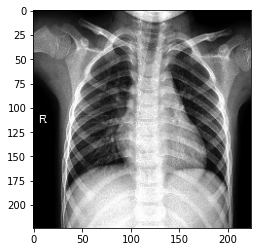

In [45]:
# for only one prediction
from keras.preprocessing import image

test_image = image.load_img('/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0101.jpeg',target_size=(224,224))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = saved_modelcnn.predict(test_image)
train_set.class_indices
if result[0][0] == 0:
    prediction = 'Covid'
elif ( result[0][0] == 1) :
    prediction = 'Normal'
else:
    prediction = 'Viral Pneumonia'
print(prediction)

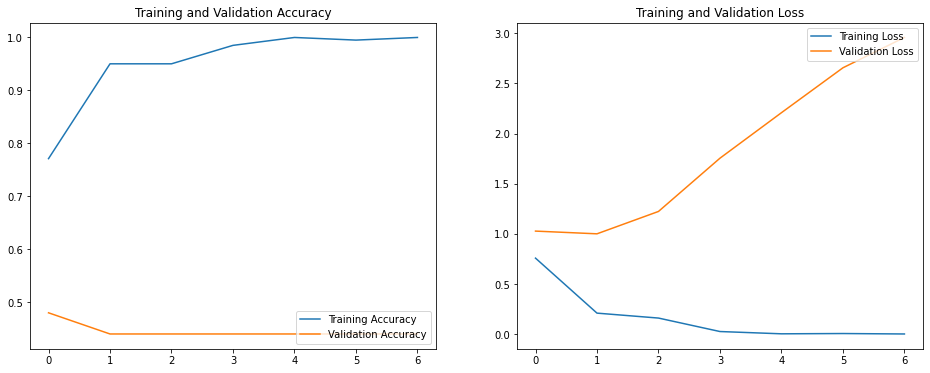

In [46]:
#Plotting the model results

#Getting the accuracy
acc3 = hist3.history['accuracy']
val_acc3 = hist3.history['val_accuracy']

#Getting the losses
loss3 = hist3.history['loss']
val_loss3 = hist3.history['val_loss']

#No of epochs it trained
epochs_range3 = hist3.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range3, acc3, label='Training Accuracy')
plt.plot(epochs_range3, val_acc3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range3, loss3, label='Training Loss')
plt.plot(epochs_range3, val_loss3, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
pred3 = saved_modelcnn.evaluate(test_set)

3/3 [==============================] - 1s 337ms/step - loss: 2.9278 - accuracy: 0.3939


In [48]:
pred3=saved_modelcnn.predict_generator(test_set)
y_pred3=np.argmax(pred3,axis=1)
print('Confusion matrix')
print(confusion_matrix(test_set.classes,y_pred3))
print('Classification_report')
target_names=['0','1','2']
print(classification_report(test_set.classes,y_pred3,target_names=target_names))

Confusion matrix
[[26  0  0]
 [20  0  0]
 [20  0  0]]
Classification_report
              precision    recall  f1-score   support

           0       0.39      1.00      0.57        26
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        20

    accuracy                           0.39        66
   macro avg       0.13      0.33      0.19        66
weighted avg       0.16      0.39      0.22        66

